In [8]:
import sqlite3
import pandas as pd

## creating a connection
database = './chinook.db'

conn = sqlite3.connect(database)

## importing tables 
tables = pd.read_sql("""SELECT name, type FROM sqlite_master WHERE type IN ("table", "view");""", conn)

tables

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


In [9]:
pd.read_sql("""PRAGMA table_info(customers);""", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,CustomerId,INTEGER,1,None,1
1,1,FirstName,NVARCHAR(40),1,None,0
2,2,LastName,NVARCHAR(20),1,None,0
3,3,Company,NVARCHAR(80),0,None,0
4,4,Address,NVARCHAR(70),0,None,0
5,5,City,NVARCHAR(40),0,None,0
6,6,State,NVARCHAR(40),0,None,0
7,7,Country,NVARCHAR(40),0,None,0
8,8,PostalCode,NVARCHAR(10),0,None,0
9,9,Phone,NVARCHAR(24),0,None,0


In [11]:
pd.read_sql("""
SELECT c.country AS Country, SUM(i.total) AS Sales FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country ORDER BY Sales DESC LIMIT 5; 
""", conn)

,Country,Sales
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48


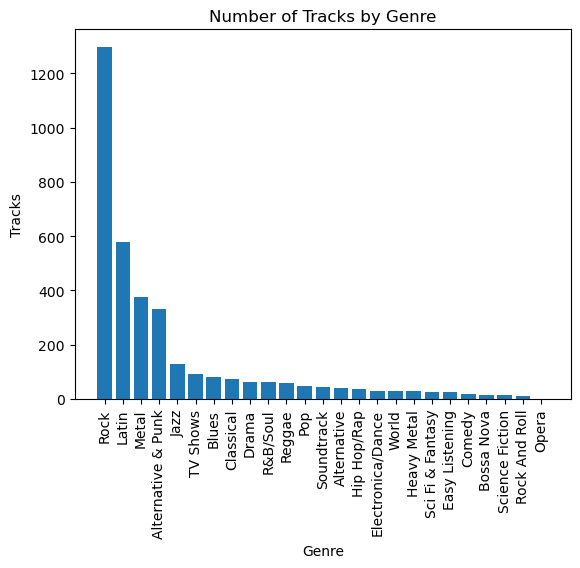

In [14]:
import matplotlib.pyplot as plt

# Define the SQL query
sql = """
SELECT g.Name AS Genre, COUNT(t.TrackId) AS Tracks
FROM genres g JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY Genre ORDER BY Tracks DESC;
"""

# Read the data into a dataframe
data = pd.read_sql(sql, conn)

# Plot the data as a bar chart
plt.bar(data.Genre, data.Tracks)
plt.title("Number of Tracks by Genre")
plt.xlabel("Genre")
plt.ylabel("Tracks")
plt.xticks(rotation=90)
plt.show()

In [1]:
# Start using LLMs
import os
from dotenv import load_dotenv

load_dotenv()

#os.environ["HUGGINGFACEHUB_API_TOKEN"]
openai_api_key = os.environ['OPENAI_API_KEY']

In [8]:
# create_sql_agent : an agent designed to interact with RDBMS
# SQLDatabaseToolkit : a toolkit providing non-parametric schema information for the agent, such as table structures and query examples.
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain.agents import AgentExecutor
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

db = SQLDatabase.from_uri('sqlite:///chinook.db')

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
)

In [9]:
# available tools
# sql_db_query: Executes the provided SQL query and returns the results. Displays an error message if the query is invalid.
# sql_db_schema: Provides the schema (table structure) and sample rows from the specified table(s).
# sql_db_list_tables: Lists all tables within the database when given no input.
# sql_db_query_checker: Verifies the syntax and validity of the SQL query before execution to prevent errors.
[tool.name for tool in toolkit.get_tools()]

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [18]:
agent_executor.invoke("Describe the playlisttrack table")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksThe table "playlist_track" exists in the database. Now, I will query the schema to understand its structure and fields.  
Action: sql_db_schema  
Action Input: "playlist_track"  
CREATE TABLE playlist_track (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES tracks ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES playlists ("PlaylistId")
)

/*
3 rows from playlist_track table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/I now know the final answer. The `playlist_track` table contains two columns: `PlaylistId` and `TrackId`. It has a composite primary key consisting of both columns and includes foreign key references to the `tracks` and `playlists` tables. 

Final Answer: The `playlist_track`

{'input': 'Describe the playlisttrack table',
 'output': 'The `playlist_track` table has two columns: `PlaylistId` (INTEGER, NOT NULL) and `TrackId` (INTEGER, NOT NULL). It has a primary key on both columns and foreign keys referencing the `tracks` and `playlists` tables.'}

In [38]:
agent_executor.agent.runnable.get_prompts()

[PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': "sql_db_query - Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.\nsql_db_schema - Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3\nsql_db_list_tables - Input is an empty string, output is a comma-separated list of tables in the database.\nsql_db_query_checker - Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!", 'to

In [19]:
agent_executor.invoke("playlist_track 테이블 구조를 한국어로 알려줘")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksI see that the `playlist_track` table exists. Now, I will check its schema to provide the structure in Korean.  
Action: sql_db_schema  
Action Input: "playlist_track"  
CREATE TABLE playlist_track (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES tracks ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES playlists ("PlaylistId")
)

/*
3 rows from playlist_track table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/I can now summarize the structure of the `playlist_track` table in Korean.

Final Answer: `playlist_track` 테이블은 두 개의 열로 구성되어 있습니다: 
1. `PlaylistId` (정수형, 필수) - 재생 목록의 ID
2. `TrackId` (정수형, 필수) - 트랙의 ID

이 두 열은 복합 기본 키로 설정되어 있으며, 각각 `tracks` 테이블의 `TrackId`와 `playlists` 테이블의 `PlaylistId

{'input': 'playlist_track 테이블 구조를 한국어로 알려줘',
 'output': '`playlist_track` 테이블은 두 개의 열로 구성되어 있습니다: \n1. `PlaylistId` (정수형, 필수) - 재생 목록의 ID\n2. `TrackId` (정수형, 필수) - 트랙의 ID\n\n이 두 열은 복합 기본 키로 설정되어 있으며, 각각 `tracks` 테이블의 `TrackId`와 `playlists` 테이블의 `PlaylistId`를 참조하는 외래 키입니다.'}

In [20]:
agent_executor.agent.runnable.get_prompts()

[PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': "sql_db_query - Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.\nsql_db_schema - Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3\nsql_db_list_tables - Input is an empty string, output is a comma-separated list of tables in the database.\nsql_db_query_checker - Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!", 'to

In [21]:
agent_executor.invoke('매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksThe relevant table for revenue data seems to be the `invoices` table, which likely contains information about sales and the corresponding customers. I'll check the schema of the `invoices` and `customers` tables to find the necessary columns to identify the countries with the highest sales.

Action: sql_db_schema  
Action Input: invoices, customers  
CREATE TABLE customers (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("Sup

{'input': '매출이 가장 많은 국가 다섯 곳을 한국어로 알려줘', 'output': '미국, 캐나다, 프랑스, 브라질, 독일'}

In [25]:
agent_executor.invoke('what is the total number of tracks and the average length of tracks by genre?')



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksI see that there are several tables, but the ones that seem relevant for tracks and genres are the `tracks` and `genres` tables. I will now check their schemas to understand their structure and the relevant columns I can use for my query. 

Action: sql_db_schema  
Action Input: "tracks, genres"  
CREATE TABLE genres (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from genres table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE tracks (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN K

{'input': 'what is the total number of tracks and the average length of tracks by genre?',
 'output': 'The total number of tracks and the average length of tracks by genre are as follows:\n\n1. Genre: Rock, Total Tracks: 1297, Average Length: 283910 ms\n2. Genre: Latin, Total Tracks: 579, Average Length: 232859 ms\n3. Genre: Metal, Total Tracks: 374, Average Length: 309749 ms\n4. Genre: Alternative & Punk, Total Tracks: 332, Average Length: 234353 ms\n5. Genre: Jazz, Total Tracks: 130, Average Length: 291755 ms\n6. Genre: TV Shows, Total Tracks: 93, Average Length: 2145041 ms\n7. Genre: Blues, Total Tracks: 81, Average Length: 270359 ms\n8. Genre: Classical, Total Tracks: 74, Average Length: 293867 ms\n9. Genre: Drama, Total Tracks: 64, Average Length: 2575283 ms\n10. Genre: R&B/Soul, Total Tracks: 61, Average Length: 220066 ms'}

In [26]:
agent_executor.invoke('장르별 총 트랙 수와 평균 길이를 한국어로 알려줘')



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksThe "tracks" and "genres" tables seem relevant for calculating the total number of tracks and the average length grouped by genre. I will check the schema of these two tables to identify the relevant columns for my query.

Action: sql_db_schema  
Action Input: "tracks, genres"  
CREATE TABLE genres (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from genres table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE tracks (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("MediaTypeId") 

{'input': '장르별 총 트랙 수와 평균 길이를 한국어로 알려줘',
 'output': '장르별 총 트랙 수와 평균 길이는 다음과 같습니다:\n- Rock: 총 트랙 수 1297, 평균 길이 283,910 밀리초\n- Latin: 총 트랙 수 579, 평균 길이 232,859 밀리초\n- Metal: 총 트랙 수 374, 평균 길이 309,749 밀리초\n- Alternative & Punk: 총 트랙 수 332, 평균 길이 234,353 밀리초\n- Jazz: 총 트랙 수 130, 평균 길이 291,755 밀리초\n- TV Shows: 총 트랙 수 93, 평균 길이 2,145,041 밀리초\n- Blues: 총 트랙 수 81, 평균 길이 270,359 밀리초\n- Classical: 총 트랙 수 74, 평균 길이 293,867 밀리초\n- Drama: 총 트랙 수 64, 평균 길이 2,575,284 밀리초\n- R&B/Soul: 총 트랙 수 61, 평균 길이 220,066 밀리초'}

In [39]:
# Prompt engineering
create_sql_agent?

In [10]:
prompt_prefix = """ 
##Instructions:
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
As part of your final answer, ALWAYS include an explanation of how to got to the final answer, including the SQL query you run. Include the explanation and the SQL query in the section that starts with "Explanation:".

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don\'t know" as the answer.

##Tools:

"""

prompt_format_instructions = """ 
Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.

Explanation:

<===Beging of an Example of Explanation:

I joined the invoices and customers tables on the customer_id column, which is the common key between them. This will allowed me to access the Total and Country columns from both tables. Then I grouped the records by the country column and calculate the sum of the Total column for each country, ordered them in descending order and limited the SELECT to the top 5.

```sql
SELECT c.country AS Country, SUM(i.total) AS Sales
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY Country
ORDER BY Sales DESC
LIMIT 5;
```

===>End of an Example of Explanation
"""

In [43]:
# llm = ChatOpenAI(model="gpt-4o-mini")
llm = ChatOpenAI(model="gpt-4o-mini")  # expensive!

agent_executor = create_sql_agent(
    prefix=prompt_prefix,
    format_instructions=prompt_format_instructions,
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    top_k=10
)

result = agent_executor.invoke("What are the top 5 best-selling albums and their artists?")



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksI need to focus on the `albums`, `artists`, and `invoice_items` tables to find the best-selling albums along with their artists. I will first check the schema of these tables to identify the relevant columns I can use in my query.

Action: sql_db_schema  
Action Input: "albums, artists, invoice_items"  
CREATE TABLE albums (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES artists ("ArtistId")
)

/*
3 rows from albums table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE artists (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from artists table:
A

ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `I don't know.`
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [45]:
create_sql_agent?

In [47]:
from IPython.display import Markdown, HTML, display


def printmd(string):
    display(Markdown(string))


printmd(result['output'])

The top 5 best-selling albums and their artists are:

1. 'Minha Historia' by 'Chico Buarque' with 27 units sold
2. 'Greatest Hits' by 'Lenny Kravitz' with 26 units sold
3. 'Unplugged' by 'Eric Clapton' with 25 units sold
4. 'Acústico' by 'Titãs' with 22 units sold
5. 'Greatest Kiss' by 'Kiss' with 20 units sold

Explanation:

I joined the albums, artists, tracks, and invoice_items tables on their respective keys. This allowed me to access the Title (album name), Name (artist name), and Quantity (units sold) columns from these tables. Then I grouped the records by the album and artist and calculated the sum of the Quantity column for each group. I ordered them in descending order by the total quantity sold and limited the SELECT to the top 5.

```sql
SELECT a.Title AS album, ar.Name AS artist, SUM(ii.Quantity) AS total_sold 
FROM albums a 
JOIN artists ar ON a.ArtistId = ar.ArtistId 
JOIN tracks t ON a.AlbumId = t.AlbumId 
JOIN invoice_items ii ON t.TrackId = ii.TrackId 
GROUP BY a.AlbumId, ar.ArtistId 
ORDER BY total_sold DESC 
LIMIT 5;
```

In [12]:
# Adding further tools
from langchain.tools.file_management import (
    ReadFileTool,
    CopyFileTool,
    DeleteFileTool,
    MoveFileTool,
    WriteFileTool,
    ListDirectoryTool,
)

# PythonREPLTool : surrpot interaction between Python and NLP + creating matplotlib graph from the sql query results
# REPL : Read - Eval - Print Loop
# FileManagementToolkit : saving files in a specific directory from agent results(graph in here) 
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain.agents.agent_toolkits import FileManagementToolkit

working_directory = os.getcwd()

tools = FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"], ).get_tools()
tools.append(PythonREPLTool())

tools.extend(SQLDatabaseToolkit(db=db, llm=llm).get_tools())
tools

[ReadFileTool(root_dir='/Users/oliverjoo/Dev/Pycharm/LLM-LangChain/for_LLM_AI'),
 WriteFileTool(root_dir='/Users/oliverjoo/Dev/Pycharm/LLM-LangChain/for_LLM_AI'),
 ListDirectoryTool(root_dir='/Users/oliverjoo/Dev/Pycharm/LLM-LangChain/for_LLM_AI'),
 PythonREPLTool(python_repl=PythonREPL(globals={'__name__': 'langchain_experimental.tools.python.tool', '__doc__': 'A tool for running python code in a REPL.', '__package__': 'langchain_experimental.tools.python', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x11d5c0c40>, '__spec__': ModuleSpec(name='langchain_experimental.tools.python.tool', loader=<_frozen_importlib_external.SourceFileLoader object at 0x11d5c0c40>, origin='/Users/oliverjoo/Dev/Anaconda/anaconda3/envs/langchain_env/lib/python3.10/site-packages/langchain_experimental/tools/python/tool.py'), '__file__': '/Users/oliverjoo/Dev/Anaconda/anaconda3/envs/langchain_env/lib/python3.10/site-packages/langchain_experimental/tools/python/tool.py', '__cached__': '/

In [13]:
[tool.name for tool in tools]

['read_file',
 'write_file',
 'list_directory',
 'Python_REPL',
 'sql_db_query',
 'sql_db_schema',
 'sql_db_list_tables',
 'sql_db_query_checker']

In [15]:
# https://smith.langchain.com/에서 랭스미스 API 키 발급받고
# .env 파일에 LANGSMITH_API_KEY를 등록한 뒤에 다음을 실행하세요.

load_dotenv()
os.environ["LANGSMITH_API_KEY"][:2]

'ls'



> Entering new AgentExecutor chain...
Thought: First, I need to query the Chinook database to get the top 5 countries by sales. Once I have the data, I will convert it into a pandas DataFrame and create a bar chart using matplotlib. Finally, I will save the figure as "figure.png". 

Action:
```json
{
  "action": "sql_db_query",
  "action_input": "SELECT BillingCountry, SUM(Total) as TotalSales FROM Invoice GROUP BY BillingCountry ORDER BY TotalSales DESC LIMIT 5;"
}
```Error: (sqlite3.OperationalError) no such table: Invoice
[SQL: SELECT BillingCountry, SUM(Total) as TotalSales FROM Invoice GROUP BY BillingCountry ORDER BY TotalSales DESC LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)Action:
```json
{
  "action": "sql_db_list_tables",
  "action_input": ""
}
```albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksAction:
```json
{
  "action": "sql_db_query",
  "action_input": "SELECT BillingCountr

Python REPL can execute arbitrary code. Use with caution.


Action:
```json
{
  "action": "Python_REPL",
  "action_input": "import pandas as pd; import matplotlib.pyplot as plt; sales_data = [('USA', 523.06), ('Canada', 303.96), ('France', 195.1), ('Brazil', 190.1), ('Germany', 156.48)]; df = pd.DataFrame(sales_data, columns=['Country', 'TotalSales']); df.set_index('Country', inplace=True); df.plot(kind='bar'); plt.title('Top 5 Countries by Sales'); plt.xlabel('Country'); plt.ylabel('Total Sales'); plt.savefig('figure.png')"
}
```Action:
```json
{
  "action": "Final Answer",
  "action_input": "The bar chart for the top 5 countries by sales has been created and saved as 'figure.png'."
}
```

> Finished chain.


{'input': 'Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요.',
 'output': "The bar chart for the top 5 countries by sales has been created and saved as 'figure.png'."}

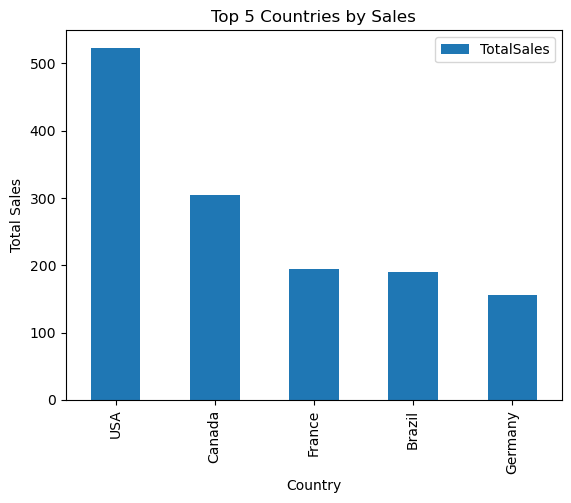

In [18]:
from langchain import hub
from langchain.agents import create_structured_chat_agent

llm = ChatOpenAI(model="gpt-4o-mini")

prompt = hub.pull("hwchase17/structured-chat-agent")

agent = create_structured_chat_agent(
    llm, tools, prompt
)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True
)
agent_executor.invoke({"input": "Chinook 데이터베이스에서 매출 상위 5개 국가를 추출하여 pandas 데이터프레임으로 저장하세요. 그런 다음 matplotlib 바 차트를 반환하세요. 결과를 현재 작업 디렉터리에 figure.png로 저장하세요."})